# Figure X.x- Cell counts plots

Goals : 

- SShow cell counts for each model

In [1]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

Used GPU:  <NVIDIA GeForce RTX 4070 Ti on Platform: NVIDIA CUDA (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im[0])
    GT_labels.append(GT_lab[0])

In [4]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]
#################
cellpose_paths = [f / "Cellpose" for f in fold_paths]
stardist_paths = [f / "starDist" for f in fold_paths]

swin_predictions = [get_predictions(p)[0] for p in swin_paths]
segresnet_predictions = [get_predictions(p)[0] for p in segresnet_paths]
cellpose_predictions = [get_predictions(p)[0] for p in cellpose_paths]
stardist_predictions = [get_predictions(p)[0] for p in stardist_paths]

In [5]:
wnet_path = DATA_PATH / "RESULTS/WNET_RETRAIN/inference/WNet"
wnet_instance = [imread(str(f)) for f in wnet_path.glob("*.tif")]
wnet_instance.reverse()

## Computations

For the choice of thresholds, see notebooks in the `thresholds_opti/` folder.

In [6]:
swin_thresholded = [np.where(swin > 0.4, swin, 0) for swin in swin_predictions]
segresnet_thresholded = [np.where(segresnet > 0.3, segresnet, 0) for segresnet in segresnet_predictions]

In [7]:
swin_instance = []
segresnet_instance = []

for i in range(len(fold_paths)):
    swin_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                         )
    segresnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(segresnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                              )

## Plots

In [8]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
   stardist_predictions,
   cellpose_predictions,
   segresnet_instance,
   swin_instance,
   wnet_instance
   ]
names = [
    "StarDist",
    "Cellpose",
    "SegResNet",
    "SwinUNetR",
    "WNet3D"
    ]

model_stats = []
model_ref_name = []
fold_ref = []

for j, fold in enumerate(fold_paths):
    print("Fold ", j+1)
    for i, p in enumerate(predictions):
        print(f"Validating on {names[i]}")
        # print(p[j].shape, GT_labels[j].shape)
        pred = p[j]
        if len(pred.shape) > 3:
            pred = pred.squeeze().astype(np.uint32)
        stats = [matching_dataset(
            GT_labels[j], pred, thresh=t, show_progress=False
            ) for t in taus]
        model_stats.append(stats)
        for t in taus:
            model_ref_name.append(names[i])
            fold_ref.append(j+1)
        # uncomment for ALL plots : 
        # plot_performance(taus, stats, name=names[i])
        print("*"*20)

Fold  1
Validating on StarDist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************
Validating on WNet3D
********************
Fold  2
Validating on StarDist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************
Validating on WNet3D
********************
Fold  3
Validating on StarDist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************
Validating on WNet3D
********************


In [9]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Model"] = model_ref_name
df["Fold"] = fold_ref
df["thresh"] = df.index
df.set_index(["Model", "Fold", "thresh"], inplace=True)
df

criterion    fp    tp    fn  precision    recall  \
Model    Fold thresh                                                    
StarDist 1    0.1          iou  2045  2908   477   0.587119  0.859084   
              0.2          iou  2595  2358  1027   0.476075  0.696603   
              0.3          iou  3656  1297  2088   0.261861  0.383161   
              0.4          iou  4497   456  2929   0.092065  0.134712   
              0.5          iou  4826   127  3258   0.025641  0.037518   
...                        ...   ...   ...   ...        ...       ...   
WNet3D   3    0.5          iou   974  4656  2253   0.826998  0.673904   
              0.6          iou  1640  3990  2919   0.708703  0.577508   
              0.7          iou  2400  3230  3679   0.573712  0.467506   
              0.8          iou  3397  2233  4676   0.396625  0.323202   
              0.9          iou  4704   926  5983   0.164476  0.134028   

                      accuracy        f1  n_true  n_pred  mean_true_score  \
Model    Fold thresh                                                        
StarDist 1    0.1     0.535543  0.697529    3385    4953         0.251961   
              0.2     0.394314  0.565603    3385    4953         0.225960   
              0.3     0.184207  0.311106    3385    4953         0.148547   
              0.4     0.057853  0.109379    3385    4953         0.063714   
              0.5     0.015467  0.030463    3385    4953         0.021498   
...                        ...       ...     ...     ...              ...   
WNet3D   3    0.5     0.590638  0.742643    6909    5630         0.518749   
              0.6     0.466721  0.636414    6909    5630         0.467688   
              0.7     0.346976  0.515193    6909    5630         0.396466   
              0.8     0.216670  0.356169    6909    5630         0.288912   
              0.9     0.079738  0.147699    6909    5630         0.129802   

                      mean_matched_score  panoptic_quality  by_image  
Model    Fold thresh                                                  
StarDist 1    0.1               0.293290          0.204579     False  
              0.2               0.324375          0.183468     False  
              0.3               0.387689          0.120612     False  
              0.4               0.472966          0.051732     False  
              0.5               0.573006          0.017455     False  
...                                  ...               ...       ...  
WNet3D   3    0.5               0.769767          0.571662     False  
              0.6               0.809838          0.515393     False  
              0.7               0.848045          0.436907     False  
              0.8               0.893907          0.318382     False  
              0.9               0.968467          0.143042     False  

[135 rows x 14 columns]

In [10]:
df_supervised = df.copy()
df_supervised = df.loc[["StarDist", "Cellpose", "SegResNet", "SwinUNetR"]]

In [11]:
# evaluate stats for WNet3D on an extra fold, where visual is restricted to [50:, :, :]
stats = [matching_dataset(
    GT_labels[0][50:,:,:], wnet_instance[0][50:,:,:], thresh=t, show_progress=False
    ) for t in taus]
partial_df = dataset_matching_stats_to_df(stats)
partial_df["Model"] = "WNet3D - No artifacts"
partial_df["Fold"] = 1
partial_df["thresh"] = partial_df.index
partial_df.set_index(["Model", "Fold", "thresh"], inplace=True)
df = pd.concat([df, partial_df])

In [12]:
df

criterion    fp    tp    fn  precision  \
Model                 Fold thresh                                          
StarDist              1    0.1          iou  2045  2908   477   0.587119   
                           0.2          iou  2595  2358  1027   0.476075   
                           0.3          iou  3656  1297  2088   0.261861   
                           0.4          iou  4497   456  2929   0.092065   
                           0.5          iou  4826   127  3258   0.025641   
...                                     ...   ...   ...   ...        ...   
WNet3D - No artifacts 1    0.5          iou  1584   197   144   0.110612   
                           0.6          iou  1620   161   180   0.090399   
                           0.7          iou  1649   132   209   0.074116   
                           0.8          iou  1688    93   248   0.052218   
                           0.9          iou  1751    30   311   0.016844   

                                     recall  accuracy        f1  n_true  \
Model                 Fold thresh                                         
StarDist              1    0.1     0.859084  0.535543  0.697529    3385   
                           0.2     0.696603  0.394314  0.565603    3385   
                           0.3     0.383161  0.184207  0.311106    3385   
                           0.4     0.134712  0.057853  0.109379    3385   
                           0.5     0.037518  0.015467  0.030463    3385   
...                                     ...       ...       ...     ...   
WNet3D - No artifacts 1    0.5     0.577713  0.102338  0.185674     341   
                           0.6     0.472141  0.082101  0.151744     341   
                           0.7     0.387097  0.066332  0.124411     341   
                           0.8     0.272727  0.045835  0.087653     341   
                           0.9     0.087977  0.014340  0.028275     341   

                                   n_pred  mean_true_score  \
Model                 Fold thresh                            
StarDist              1    0.1       4953         0.251961   
                           0.2       4953         0.225960   
                           0.3       4953         0.148547   
                           0.4       4953         0.063714   
                           0.5       4953         0.021498   
...                                   ...              ...   
WNet3D - No artifacts 1    0.5       1781         0.433853   
                           0.6       1781         0.378191   
                           0.7       1781         0.323786   
                           0.8       1781         0.239972   
                           0.9       1781         0.084809   

                                   mean_matched_score  panoptic_quality  \
Model                 Fold thresh                                         
StarDist              1    0.1               0.293290          0.204579   
                           0.2               0.324375          0.183468   
                           0.3               0.387689          0.120612   
                           0.4               0.472966          0.051732   
                           0.5               0.573006          0.017455   
...                                               ...               ...   
WNet3D - No artifacts 1    0.5               0.750984          0.139438   
                           0.6               0.801012          0.121549   
                           0.7               0.836448          0.104063   
                           0.8               0.879898          0.077126   
                           0.9               0.963994          0.027257   

                                   by_image  
Model                 Fold thresh            
StarDist              1    0.1        False  
                           0.2        False  
                           0.3        False  
                           0.4        False  
          

In [13]:
cell_counts = {}
for i, p in enumerate(predictions):
    cell_counts[names[i]] = []
    for j, pred in enumerate(p):
        cell_counts[names[i]].append(len(np.unique(pred)) - 1)
        
gt_cell_counts = []
for gt in GT_labels:
    gt_cell_counts.append(len(np.unique(gt)) - 1)

In [14]:
# also count cells on an extra fold - visual @ [125:, :, :]

# load first fold only
fold_4_gt = GT_labels[0][:50,:,:]
# iterate over models
for i, p in enumerate(predictions):
    fold_4_pred = p[0][:50:,:,:]
    cell_counts[names[i]].append(len(np.unique(fold_4_pred)) - 1)


In [15]:
cell_counts["GT"] = gt_cell_counts
cell_counts["GT"].append(len(np.unique(fold_4_gt)) - 1)
cell_counts_df = pd.DataFrame(cell_counts)

In [16]:
cell_counts_df

,StarDist,Cellpose,SegResNet,SwinUNetR,WNet3D,GT
0,464,315,490,575,819,540
1,301,251,330,331,379,347
2,663,491,674,693,719,631
3,432,296,402,458,463,480


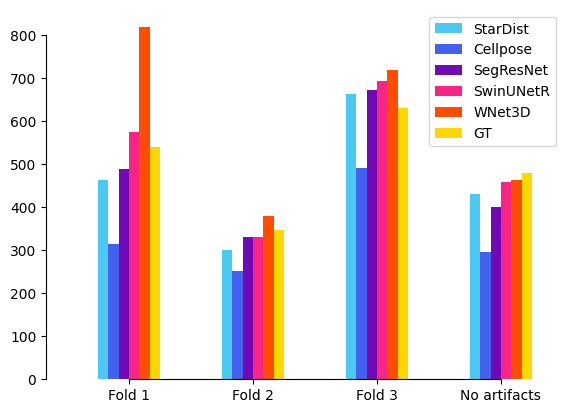

In [22]:
# make a barplot that show gt and models cell counts for each fold
with get_style_context():
    cell_counts_df.plot(kind="bar") #, colormap=COLORMAP)
    plt.xticks(np.arange(4), ["Fold 1", "Fold 2", "Fold 3", "No artifacts"], rotation=0)
    sns.despine(
        left=False,
        right=True,
        bottom=False,
        top=True,
        trim=True,
        offset={"bottom": 0, "left": 15},
    )

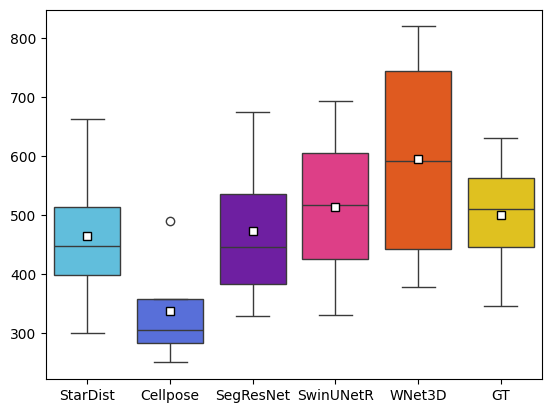

In [26]:
# show average across folds
with get_style_context():
    sns.boxplot(data=cell_counts_df, showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})

765565555.py (3): 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



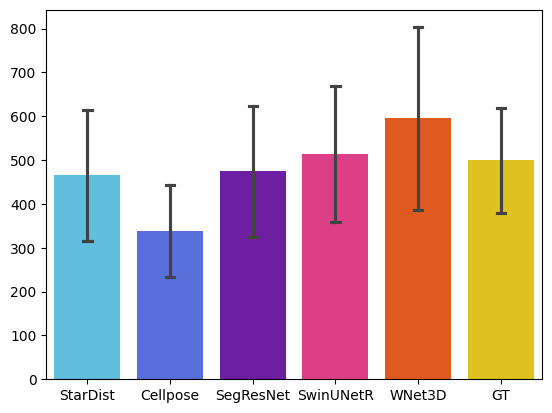

In [31]:
# show average across folds
with get_style_context():
    sns.barplot(data=cell_counts_df, estimator=np.mean, errorbar="sd", capsize=0.1)

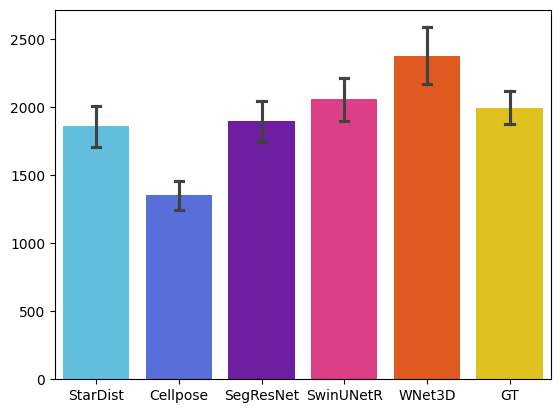

In [32]:
# show sum across folds
with get_style_context():
    sns.barplot(data=cell_counts_df, estimator=sum, errorbar="sd", capsize=0.1)